In [11]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)
library(cowplot)
library(ggplot2)
library(GGally)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



# Group proposal on developing predictive model in detecting and preventing forest fires in the Algerian regions.

In the Algerian regions(Northern Africa) of **Bejaia** and **Sidi Bel-abbes** during the period, between June 2012 and September 2012, forest fires ravaged an estimated 20,000 hectares of land. 
Our project aims to construct a prediction model for forest fires and we will use the Algerian Forest Fires Dataset, which contains data from two sub-regions.

Our target variable for this project will be the classification of fire casses, and we'd further explore the data to select strong predictor in this dataset.

**Brief explanation**
* Temperature: Degree Celsius
* RH: Relative Humidity (%)
* Ws: Wind speed (km/h)
* ISI (Initial Spread Index): estimation of the anticipated spread of a fire that is based on FFMC. 
* FFMC (fine fuel moisture code): the moisture content based on litter or other fine fuels. 
* DMC (Duff Moisture Code) and DC (Drought Code): is the average rating of moisture in the organic layers of the forest.
* BUI (Buildup Index): the total amount of fuel that can be used for a combustion reaction, this number is based on the DMC and the DC. 
* FWI (Fire Weather Index): the rating of the strength of the fire.



Tidying dataset: There are two datasets from the source, and we combined them by the following steps (with rbind() and a new column called Region) to make the prediction for both Algerian Region.

In [27]:
B_forestfire_data <- read_csv("https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1, 
                            col_types = "ncnnnnnnnnnnnf")%>%
                slice(1:124)%>%
                mutate(month = case_when(month == '06' ~ "June",
                                   month == '07' ~ "Jul",
                                   month == '08' ~ "Aug",
                                   month == '09' ~ "Sep"),
                      Region = "Bejaia")%>%
                filter(Classes != 'Classes',
                      !is.na(Classes))
                

S_forestfire_data <- read_csv("https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv", skip = 126, 
                            col_types = "ncnnnnnnnnnnnf")%>%
                mutate(month = case_when(month == '06' ~ "June",
                                   month == '07' ~ "Jul",
                                   month == '08' ~ "Aug",
                                   month == '09' ~ "Sep"),
                      Region = "Sidi Bel-abbes")%>%
                filter(Classes != 'Classes',
                      !is.na(Classes))

#combining two dataset into one for tidyness
forest_fire_data <- rbind(B_forestfire_data, S_forestfire_data)

head(forest_fire_data, n = 3)

Warning message:
“16 parsing failures.
row         col   expected      actual                                                                                                       file
123 day         a number   -           'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
123 NA          14 columns 1 columns   'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
124 day         a number   day         'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
124 year        a number   year        'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
124 Temperature a number   Temperature 'https://raw.githubusercontent.com/zjr-pjt/Proposal-Group-2/main/Algerian_forest_fires_dataset_UPDATE.csv'
... ........... .......... ........... ..............................................

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,June,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia
2,June,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,Bejaia
3,June,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia


In [28]:
#Verifying the size of dataset
nrow(forest_fire_data)

[1] 243

**!!!We observed from the plots, and then we explain which predictors we found (has influence on the Classes) should to be added to the prediction model... ...****Exploratory Steps**

Firstly,this is a small dataset and we decided to slice the data with 76% for the training set and 24% for the testing set. This will ensure that the training set is large enough while still having sufficient data for the testing set to test the accuracy

We explored the data to see their sizes and the count under each class. We made tables and plots of FWI values evaluating whether a fire class always has a greater FWI value than a non-fire class in two subregions.

We'll use different variables to create plots to visualize the relationships between the vectors.


**!!! We observed from the plots, and then we explain which predictors we found (has influence on the Classes) should to be added to the prediction model... ...**

In [128]:
set.seed(100)

forest_split <- initial_split(forest_fire_data, prop = 0.76, strata = Classes)

training <- training(forest_split)
testing <- testing(forest_split)

**After splitting the data into testing and training sets, we put the training set through the ggpairs function to visualize distribution and relationships between the variables RH:Classes. This allows us to see which predictors are the strongest and decide which ones we want to work with.**

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



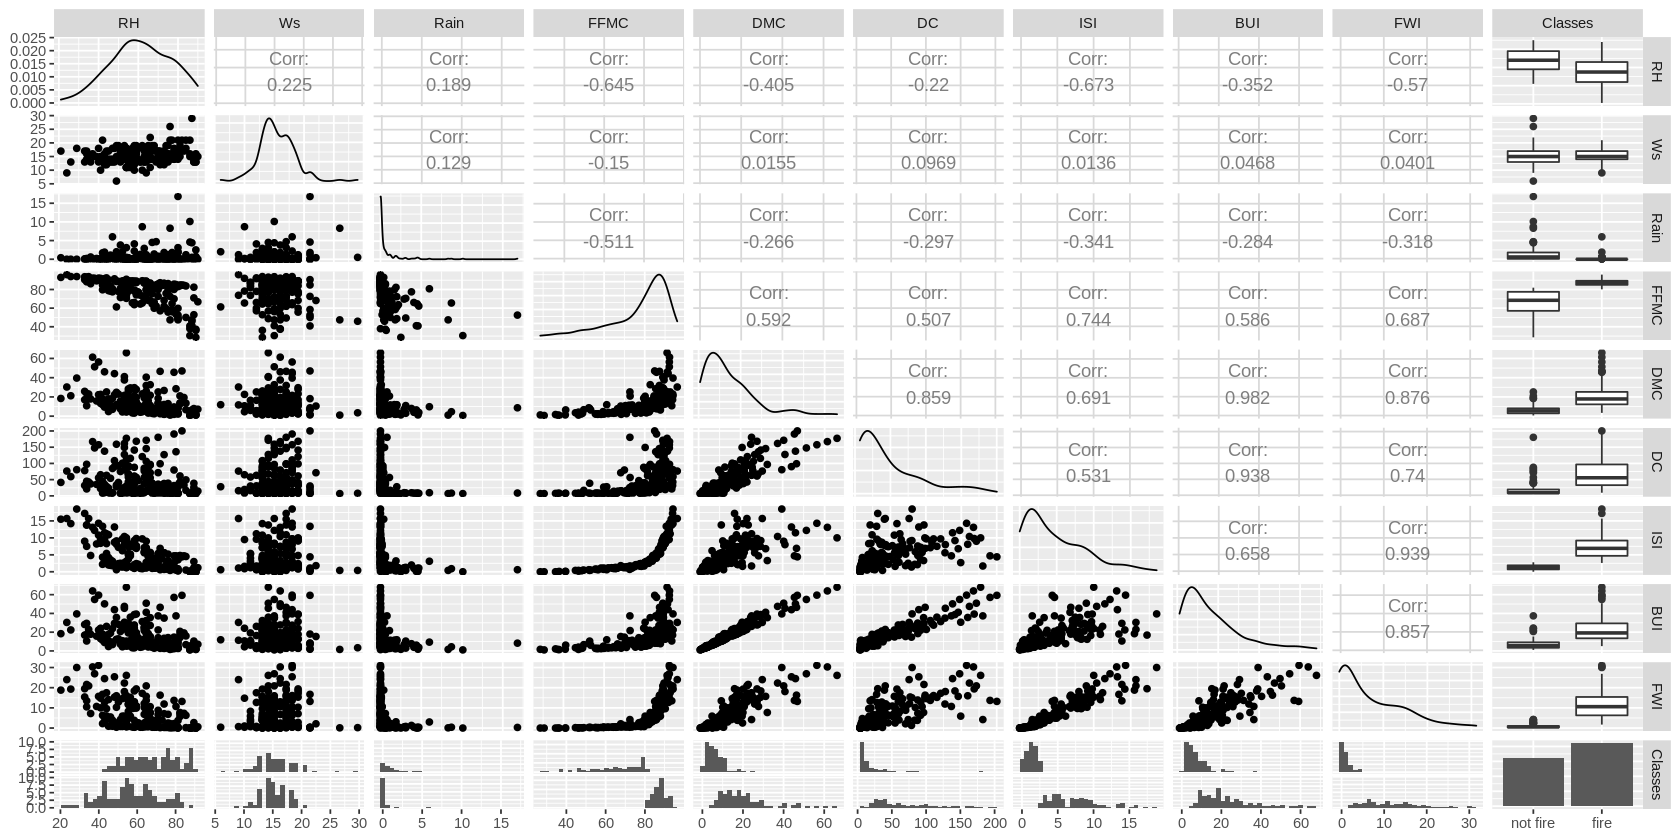

In [39]:
options(repr.plot.width = 14, repr.plot.height = 7)

pairs_plot <- training %>%
        select(RH:Classes) %>%
        ggpairs()

pairs_plot

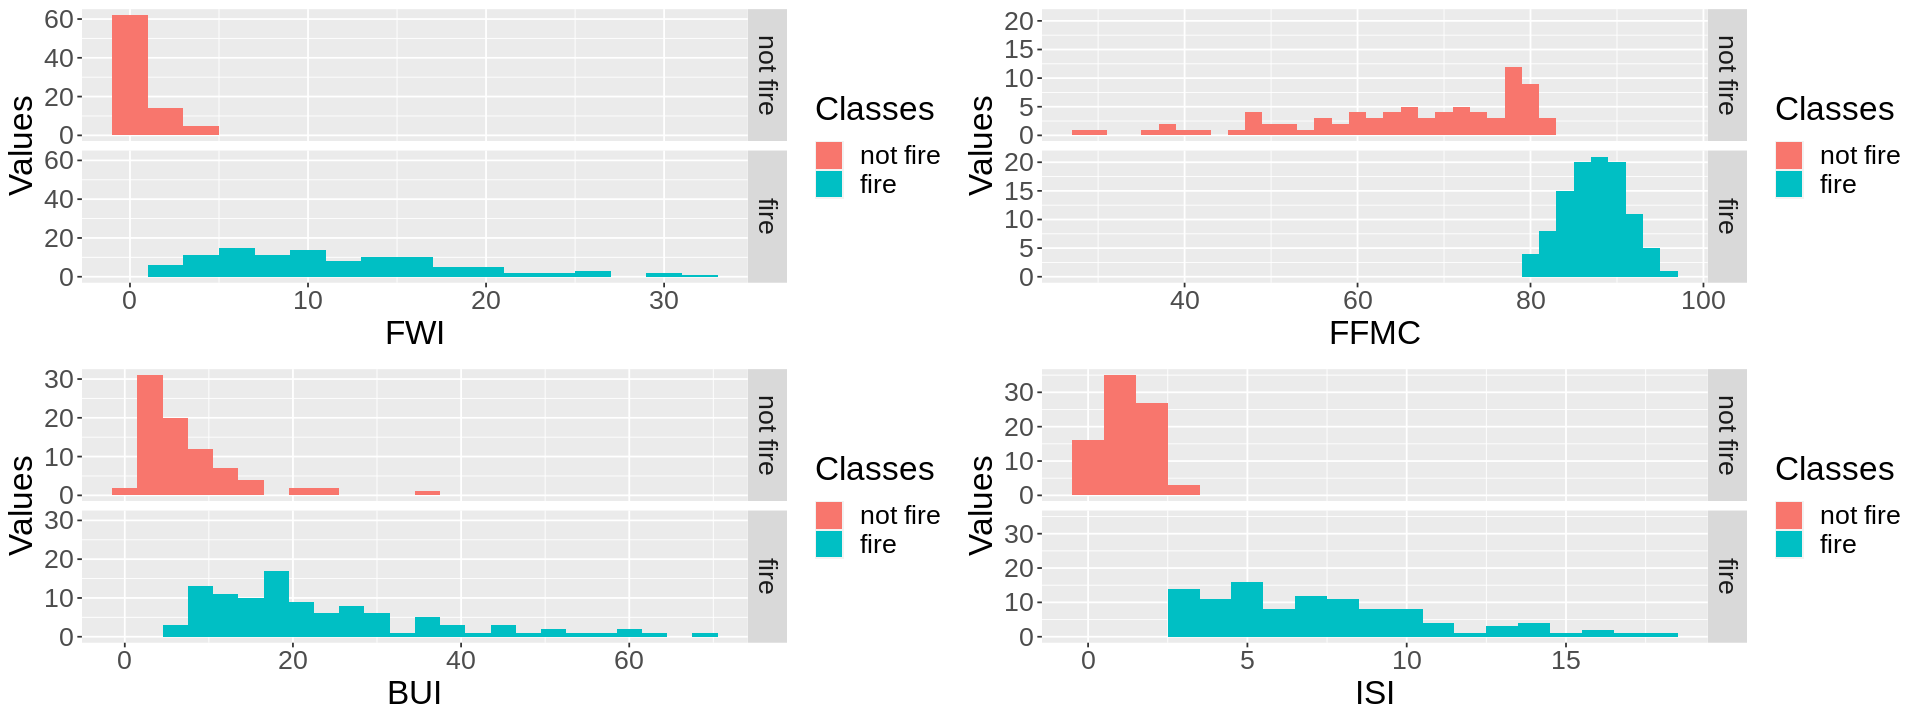

In [127]:
options(repr.plot.width = 16, repr.plot.height = 6)
#!!! need code comments

fwi_histogram <- ggplot(training, aes(x = FWI,fill = Classes))+
        geom_histogram(binwidth=2)+
        facet_grid(Classes~.)+
        labs(x = "FWI", y = "Values",fill = "Classes")+
        theme(text = element_text(size = 20))

ffmc_histogram <- ggplot(training, aes(x = FFMC,fill = Classes))+
        geom_histogram(binwidth=2)+
        facet_grid(Classes~.)+
        labs(x = "FFMC", y = "Values",fill = "Classes")+
        theme(text = element_text(size = 20))

bui_histogram <- ggplot(training, aes(x = BUI,fill = Classes))+
        geom_histogram(binwidth=3)+
        facet_grid(Classes~.)+
        labs(x = "BUI", y = "Values",fill = "Classes")+
        theme(text = element_text(size = 20))

isi_histogram <- ggplot(training, aes(x = ISI,fill = Classes))+
        geom_histogram(binwidth=1)+
        facet_grid(Classes~.)+
        labs(x = "ISI", y = "Values",fill = "Classes")+
        theme(text = element_text(size = 20))

plot_grid(fwi_histogram, ffmc_histogram, bui_histogram, isi_histogram, ncol = 2)

**Methods**

* Further tuning the classifiers using cross-validation with C = 5, which would prevent the data from under fitting or overfitting, and each observation will only be used once in a validation set.
* Picking a K value by visualizing the Accuracy Estimation vs. Number of Neighbours for the classification models.
* Developing two models: one with only FWI as predictor and the other with ... ... . Testing and comparing their accuracies on testing datasets.
* !!!! we also need to conclude the visualization for the classification result  referring to @piazza 679**


**Expected outcomes and significance**

We expect to find that the model could predict future forest fires with an accuracy above 82%. This result can be applied to proactive methods to prevent and detect fire signals. 

We can think of further inquiries such as, does the model fit for other regions in this country, and what about other countries?


* !!!observed that set.seed() also had influence over K-value, when set.seed is ..., the best K is ..., and when set.seed() is ..., the best K changes to ...
This could be a further exploratory step to .... ....

**Creating Recipes and Specification**


In [113]:
#models and recipes for both regions. 
set.seed(50)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

f_recipe <- recipe(Classes ~ FWI + FFMC + BUI + ISI, data = training) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())

!!! explanation for following steps

In [120]:
#performing cross-validation and then find the best K value from model tuning process
set.seed(30)

fires_fold <- vfold_cv(training, v = 5, strata = Classes)

#!!!
knn_results<- workflow() %>%
    add_recipe(f_recipe)%>%
    add_model(knn_spec)%>%
    tune_grid(resamples = fires_fold, grid= 10) %>%
    collect_metrics()

accuracies <- knn_results %>%
        filter(.metric == 'accuracy')

k_plot <- ggplot(accuracies, aes(x = neighbors , y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate")+
    scale_x_continuous(breaks = seq(0,14, by = 1))+
    theme(text = element_text(size = 14))+
    ggtitle("K Vs. Accuracy")


! Fold1: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold2: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold3: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold4: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold5: internal: No observations were detected in `truth` for level(s): 'Classe...



! Fold1: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold2: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold3: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold4: internal: No observations were detected in `truth` for level(s): 'Classe...

! Fold5: internal: No observations were detected in `truth` for level(s): 'Classe...



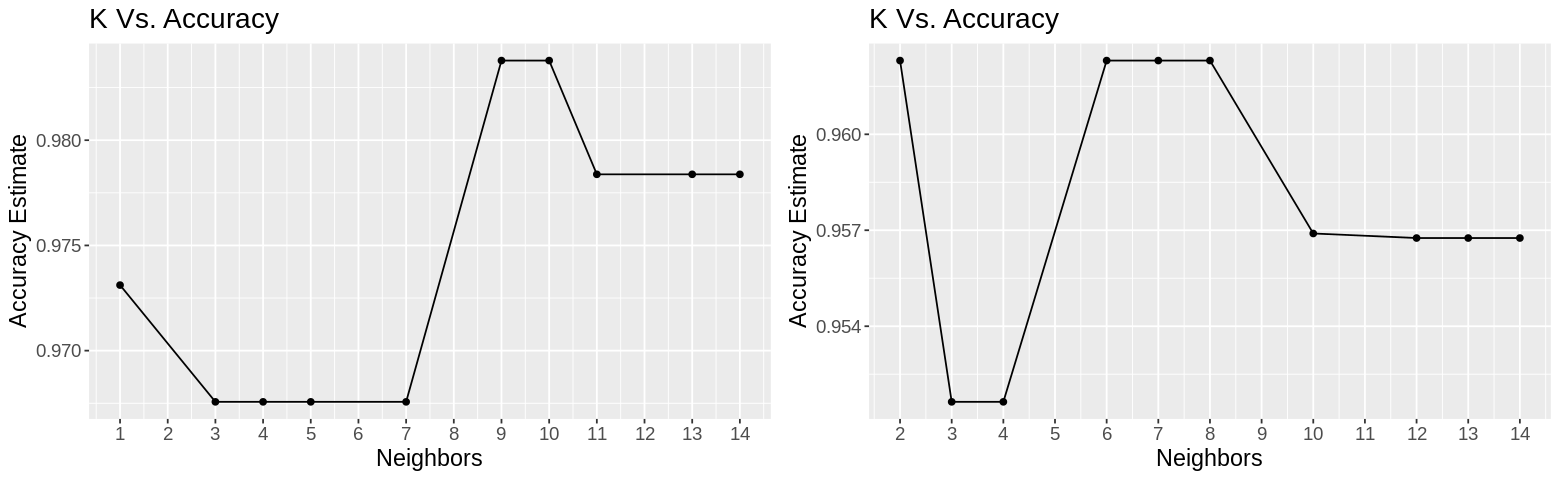

In [122]:
options(repr.plot.width = 13, repr.plot.height = 4)

#using a different seed
set.seed(50)

fires_fold_2 <- vfold_cv(training, v = 5, strata = Classes)

#!!!
knn_results_2 <- workflow() %>%
    add_recipe(f_recipe)%>%
    add_model(knn_spec)%>%
    tune_grid(resamples = fires_fold_2, grid= 10) %>%
    collect_metrics()

accuracies_2 <- knn_results_2 %>%
        filter(.metric =='accuracy')

k_plot_2 <- ggplot(accuracies_2, aes(x = neighbors , y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "Accuracy Estimate")+
    scale_x_continuous(breaks = seq(0,14, by = 1))+
    theme(text = element_text(size = 14))+
    ggtitle("K Vs. Accuracy") 

plot_grid(k_plot,k_plot_2,ncol=2)

**Best K values**!!!


In [129]:
#!!!
fire_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) %>%
        set_engine("kknn")%>%
        set_mode("classification")


In [124]:
#!!!
fire_fit <- workflow()%>%
        add_recipe(f_recipe)%>%
        add_model(fire_spec)%>%
        fit(data = training)

In [125]:
#!!!
fire_prediction <- predict(fire_fit, testing)%>%
        bind_cols(testing)

head(fire_prediction, n = 5)

.pred_class,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
not fire,3,June,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia
fire,7,June,2012,33,54,13,0.0,88.2,9.9,30.5,6.4,10.9,7.2,fire,Bejaia
not fire,10,June,2012,28,79,12,0.0,73.2,9.5,46.3,1.3,12.6,0.9,not fire,Bejaia
fire,11,June,2012,31,65,14,0.0,84.5,12.5,54.3,4.0,15.8,5.6,fire,Bejaia
not fire,14,June,2012,30,78,20,0.5,59.0,4.6,7.8,1.0,4.4,0.4,not fire,Bejaia


In [126]:
fire_metrics <- fire_prediction %>%
            metrics(truth = Classes, estimate = .pred_class)
fire_metrics


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9649123
kap,multiclass,0.9287500


!!!